In [ ]:
!pip install nano-autograds

In [ ]:
from autograd.core.engine import Value
from autograd.core.nn import Neuron, Layer, MLP
from autograd.core.Graph import draw_dot
from graphviz import Digraph


# Yet another propagation tutorial

I am using the awesome code of [Andrej Karpathy](https://github.com/karpathy/micrograd) to demonstrate back propgation and gradient descent. However, to leave nothing "under the hood" we will not import anything but rather only copy paste the few things we need.

The basic class we use is `Value` this is a class that holds a single variable $x$  (a floating point), but also keeps track of the _gradient_ (really partial derivative here since its single dimension)  $\tfrac{\partial f}{\partial x}$ with respect to some function $f$ that depends on $x$ and other variables.

The trick is that we don't know $f$ in advance. Rather, we would build $f$ by applying operations to $x$, and then use the `backward' operation to compute the derivatives $\tfrac{\partial f}{\partial u}$ with respect to all the intermediate values $u$ that $f$ depends on.

For example, if we will run the following code

```
a = Value(5)
def f(x): return (x+2)**2 + x**3
y = f(a)
y.backward()
print(y.data, a.grad)
```
then the values printed will be `174` and `89` since $(5+2)^2 + 5^3 = 174$ and the derivative of $(x+2)^2 + x^3 = x^3 + x^2 + 4x + 4$ equals  $3x^2 + 4x + 2$

See also this [deepnote notebook](https://deepnote.com/publish/f898cdd4-4815-42ad-ba57-ae0b8b733492) building this class iteratively

The class `Value` holds a value but also keeps track of the way the value was computed, and which other `Value` objects it depended on.

For example if `a` is a `Value` holding the number $5$, and `b` is obtained by `b = a*a*a + a*a*a` then this is equivalent to the code

```
a = Value(5)
t1 = a*a
t2 = t1*a
t3 = a*a
t4 = t3*a
b = t2+t4
```

Each one of these intermediate values will be a `Value` object that keeps a backlink to the `Value` objects that was used in its computation (its "children"), and has a `_backward` method that adds to these children the contribution from its gradient.

If we run the computation above, then `b.data` will equal $5^3 + 5^3 = 250$. If we then do `b.backward()` then `a.grad` will equal $\tfrac{db}{da} = (2a^3)' = 6a^2 = 150$

In [ ]:
a = Value(5)
b = a*a*a+a*a*a
b.data

250

In [ ]:
b.backward()
a.grad , 6*a.data**2

(150, 150)

## Fuller implementation of the `Value` class

We now add to `Value` the various arithmetic operations.

Let's check that we get what we intended to get

In [ ]:
a = Value(5)
def f(x): return (x+2)**2 + x**3
y = f(a)
y.backward()
print(y.data, a.grad)

174 89


In [ ]:
u = Value(5)
v = u**3
w= u+u
z = v*w
print(f"u={u.data},v={v.data},w={w.data},z={z.data}")

u=5,v=125,w=10,z=1250


In [ ]:
z.backward()
print(f"Gradients: u={u.grad},v={v.grad},w={w.grad},z={z.grad}")

Gradients: u=1000,v=10,w=125,z=1


## Stochastic gradient descent

Back propagation is of course used to run the stochastic gradient descent algorithm. We will start by using backpropagation to fit a line to data, but do this using a `pytorch` like approach. We define a `Linear` class that has two weights $a$ and $b$, and such that if $f$ is a `Linear` object then $f(x)=a\cdot x+ b+\cdot x$.

Now we can fit a line to data $\{ (x_i,y_i) \}$ by defining a linear model $f$, computing using backpropagation the gradient $\nabla = \nabla \sum_i (f(x_i)-y_i)^2$ and then updating $(a,b) \leftarrow (a,b) - \eta \nabla$.

With backpropagation, computing the gradient of the loss is as easy as computing the loss itself.

In [ ]:
import random
class Linear:
  def __init__(self):
    self.a,self.b = Value(random.random()),Value(random.random())
  def __call__(self,x): return self.a*x+self.b
  def zero_grad(self):
    self.a.grad, self.b.grad = 0,0

def loss(y,y_): return (y-y_)**2

In [ ]:
# Plotting functions - feel free to skip this cell
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
import random
import numpy as np


# Helper function to plot datapoints and function approximators
def plot(X,Y,f=None,pt_legend='',line_legend='',title='', ylim=None):
    fig, ax = plt.subplots(figsize=(8,8))
    ln = None
    if Y:
        ln= ax.scatter(X,Y, color='blue', label=pt_legend)
    if f:
        ln = ax.plot(X,[f(x) for x in X], color='red', label=line_legend)[0]
    if pt_legend or line_legend:
        ax.legend()
    if ylim:
        ax.set_ylim(*ylim)
    return fig,ax,ln


# Utility code to animate SGD
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
Ys = []
X = []
model = None
fig, ax, ln = None, None, None
fig = None;

def updateY():
    Ys.append([float(model(x)) for x in X])

def initY():
    global Ys
    Ys = []
    updateY()

def animate(gif="", skips = 1):
    def update(frame):
        ln.set_data(X, Ys[frame])
        return ln,

    ani = FuncAnimation(fig, update, init_func = lambda: [ln], frames=range(0,len(Ys),skips), blit=True)
    if gif:
      ani.save(gif, writer='imagemagick', fps=15)
    return HTML(ani.to_jshtml())

In [ ]:
!apt install imagemagick
from IPython.display import clear_output
clear_output() #remove this line if you need to debug installation issues

## Fitting a linear model to data

We generate the "ground truth" $a_{gt},b_{gt}$ at random in $[0,5]$ and generate $20$ samples of the form $x_i,y_i$ where $x_i$ is random in $[0,1]$ and $y_i = a_{gt}x_i + b_{gt} + \xi_i$ for noise $\xi_i$ random in $[0,1/2]$.

Ground truth: 1.65, 0.64


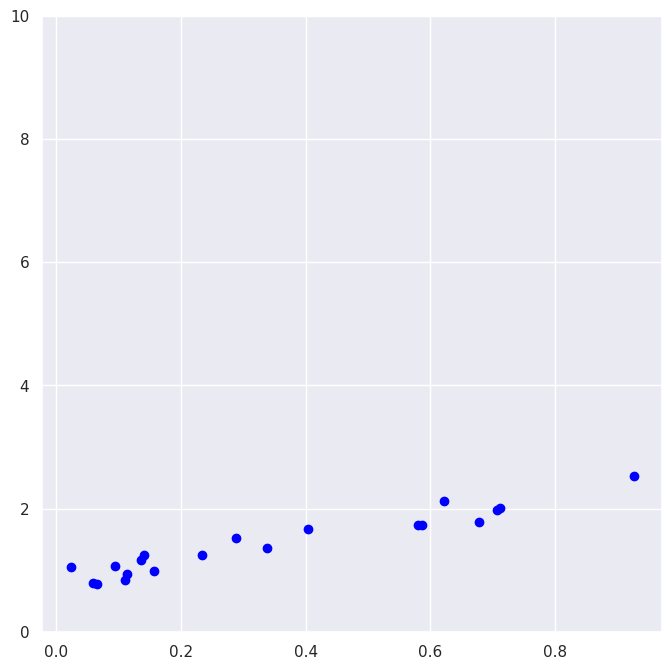

In [ ]:
n = 20
a_gt , b_gt = 5*random.random(), 5*random.random()
X = [random.random() for i in range(20)]
Y = [a_gt*x + b_gt + 0.5*random.random() for x in X]
print(f"Ground truth: {a_gt:.2f}, {b_gt:.2f}")
fig, ax, ln = plot(X,Y, ylim=(0,10));

## Training loop:
For a random sample $(x,y)$, we compute the gradient $\nabla = \nabla (f(x)-y)^2$ (which is a vector in $\mathbb{R}^2$) and update $(a,b) \leftarrow (a,b) - \eta \cdot \nabla$

Initial params: 0.83, 0.81
Final params: 1.56, 0.86


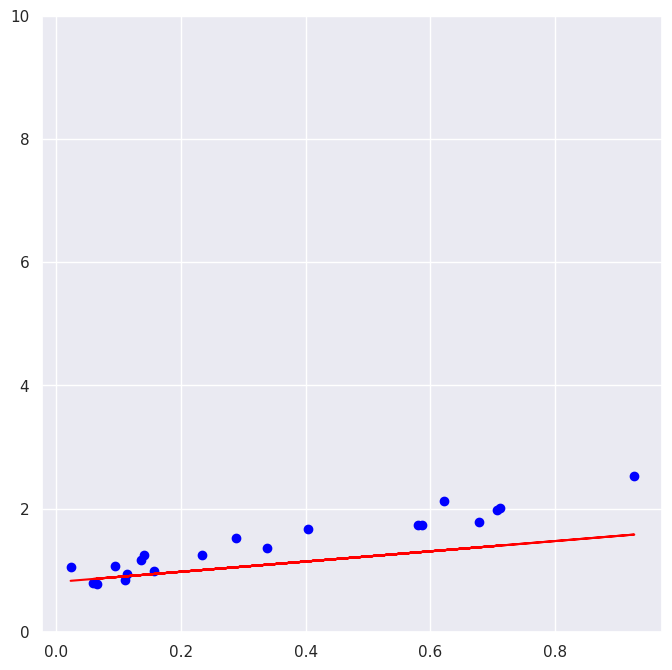

In [ ]:
model = Linear()
fig, ax, ln = plot(X,Y, model, ylim=(0,10));
print(f"Initial params: {float(model.a):.2f}, {float(model.b):.2f}")
η = 0.03
epochs = 20
initY()
for t in range(epochs):
  for x,y in zip(X,Y):
    model.zero_grad()
    loss = (model(x)-y)**2
    loss.backward()
    model.a , model.b = (model.a - η*model.a.grad  , model.b - η*model.b.grad)
    updateY()
print(f"Final params: {float(model.a):.2f}, {float(model.b):.2f}")

In [ ]:
animate("regression.gif",10)

## Neural networks

We now follow Karpathy and do the same for a more sophisticated Neural network - a depth 3 fully connected neural net with two inputs and one outputs, and two hidden layers, each with $16$ neurons.

We will use this to fit the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

This part is based on [Karpathy's demo notebook](https://github.com/karpathy/micrograd/blob/master/demo.ipynb)



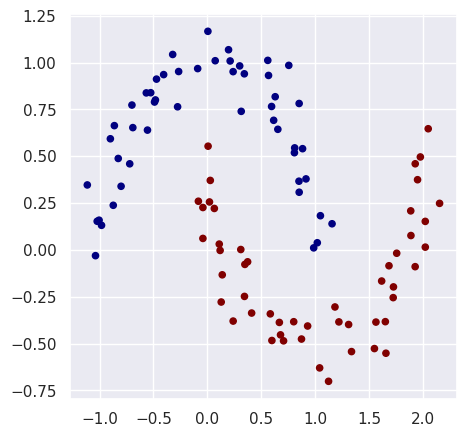

In [ ]:
from sklearn.datasets import make_moons, make_blobs
X, Y = make_moons(n_samples=100, noise=0.1)

Y = Y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet');

The Neural network is obtained as follows:

We define the `neuron` function to be a map that takes weights $w$ and inputs $x$ (both vectors in $\mathbb{R}^n$ for some $n$) and returns either $\sum x_iw_i$ or $ReLU(\sum x_iw_i) = \max \{ \sum x_i w_i, 0 \}$ depending on whether the optional parameter `relu` is `True`.

The neural network `Net` has a weight pair $w_{i,j}$ for each pair of units $i,j$ in adjacent layers. It is obtained by applying the `neuron` function in each layer to the corresponding weights and the activations of the previous layer.

In [ ]:
def neuron(weights,inputs, relu =True):
  """A single neuron computing either a linear function of inputs or a ReLU applied to linear function"""
  v =  sum(weights[i]*x for i,x in enumerate(inputs))
  return v.relu() if relu else v


class Net:
  """Depth 3 fully connected neural net with one two inputs and output"""

  def __init__(self,  N=16):
    self.layer_1 = [[Value(),Value()] for i in range(N)]
    self.layer_2 = [ [Value() for j in range(N)] for i in range(N)]
    self.output =  [ Value() for i in range(N)]
    self.parameters = [v for L in [self.layer_1,self.layer_2,[self.output]] for w in L for v in w]


  def __call__(self,x):
    layer_1_vals = [neuron(w,x) for w in self.layer_1]
    layer_2_vals = [neuron(w,layer_1_vals) for w in self.layer_2]
    return neuron(self.output,layer_2_vals,relu=False)

  def zero_grad(self):
    for p in self.parameters:
      p.grad=0

In [ ]:
model = Net()

In [ ]:
model = Net()
epochs = 15

η = 1
for t in range(epochs):
  loss = sum([(1+ -y*model(x)).relu() for (x,y) in zip(X,Y)])/len(X)
  model.zero_grad()
  loss.backward()
  for p in model.parameters:
    p.data -= η*p.grad
  acc = sum(float(model(x))*y>0 for (x,y) in zip (X,Y))
  print(f"Epoch {t} mean loss {loss.data} Accuracy {acc*100 / len(X):.0f}%")


Epoch 0 mean loss 1.2944275928897877 Accuracy 86%
Epoch 1 mean loss 0.3349771665884513 Accuracy 87%
Epoch 2 mean loss 0.31459226426336223 Accuracy 87%
Epoch 3 mean loss 0.300467070716942 Accuracy 87%
Epoch 4 mean loss 0.28809762348891943 Accuracy 88%
Epoch 5 mean loss 0.277688644000657 Accuracy 88%
Epoch 6 mean loss 0.2698968052866117 Accuracy 89%
Epoch 7 mean loss 0.26167156116950946 Accuracy 89%
Epoch 8 mean loss 0.25488289325064517 Accuracy 89%
Epoch 9 mean loss 0.2496618903272673 Accuracy 88%
Epoch 10 mean loss 0.2472445204284868 Accuracy 88%
Epoch 11 mean loss 0.2484858028373946 Accuracy 87%
Epoch 12 mean loss 0.2504645435062396 Accuracy 88%
Epoch 13 mean loss 0.24359678551791086 Accuracy 85%
Epoch 14 mean loss 0.25626582755181193 Accuracy 88%


In [ ]:

inputs = [list(map(Value, xrow)) for xrow in X]

# forward the model to get scores
scores = list(map(model, inputs))

draw_dot(model(scores[0:2]),'graph_wights_update')

Let's plot the decision boundary

(-1.701187730097435, 2.048812269902565)

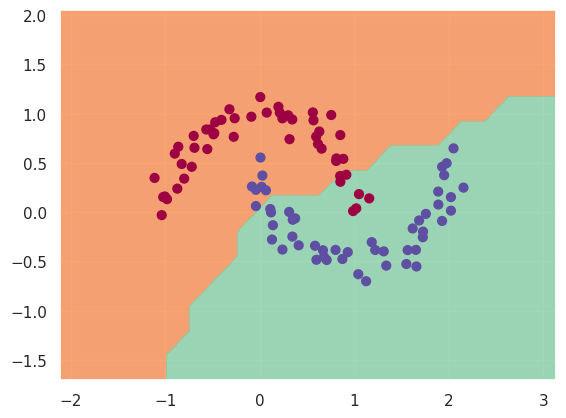

In [ ]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

For a more optimized construction ands optimization, see [Karpathy's demo notebook](https://github.com/karpathy/micrograd/blob/master/demo.ipynb)

### Animation of NN evolution

(This is slow and somewhat buggy)

In [ ]:
# Add bias
class Neuron:

  def __init__(self,params,in_dim, relu=True):
    self.relu = relu
    self.weights = [Value() for i in range(in_dim)]
    self.bias = Value(0)
    self.parameters = self.weights + [self.bias]
    params.extend(self.parameters)


  def __call__(self,X):
    v =  sum(self.weights[i]*x for i,x in enumerate(X))+self.bias
    return v.relu() if self.relu else v


class Net:
  """Depth 3 fully connected neural net with one two inputs and output"""

  def __init__(self,  N=16):
    self.N = N
    self.parameters = []
    self.layer1 = [Neuron(self.parameters,2) for i in range(N)]
    self.layer2 = [ Neuron(self.parameters,N) for j in range(N)]
    self.output =  Neuron(self.parameters,N,relu=False)



  def __call__(self,x):
    layer1_vals = [n(x) for n in self.layer1]
    layer2_vals = [n(layer1_vals) for n in self.layer2]
    return self.output(layer2_vals)

  def zero_grad(self):
    for p in self.parameters:
      p.grad=0





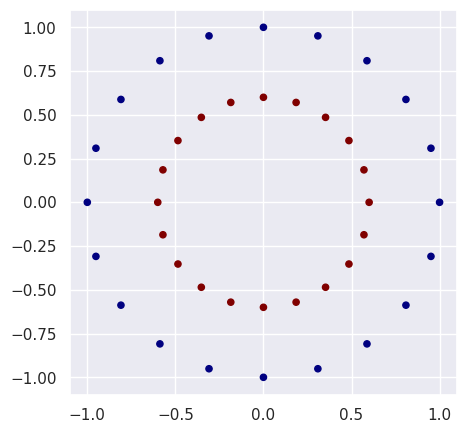

In [ ]:
from sklearn.datasets import make_moons, make_circles
X, Y = make_circles(n_samples=40, factor = 0.6)


Y = 2*(Y % 2) - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet');

In [ ]:
def copy(model):
  net = Net(model.N)
  for i,p in enumerate(model.parameters):
    net.parameters[i].data = p.data
  return net

In [ ]:
def Zvals(model):
  global X
  h = 0.25
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  inputs = [list(map(Value, xrow)) for xrow in Xmesh]
  scores = list(map(model, inputs))
  Z = np.array([s.data > 0 for s in scores])
  Z = Z.reshape(xx.shape)
  return Z


def dboundary(model):
  global X
  global Y
  h = 0.25
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  fig, ax = plt.subplots(figsize=(8,8))
  Z = Zvals(model)
  ln = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  return  fig,ax,ln

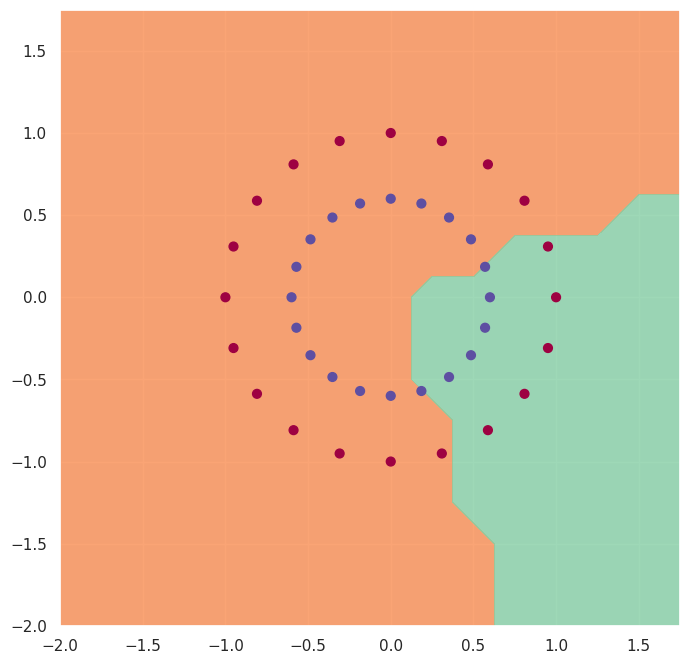

In [ ]:
model = Net()
models = [model]
fig,ax,ln = dboundary(model)


In [ ]:
epochs = 10
η = 0.05
for t in range(epochs):
  loss = sum([(1+ -y*model(x)).relu() for (x,y) in zip(X,Y)])/len(X)
  model.zero_grad()
  loss.backward()
  for p in model.parameters:
    p.data -= η*p.grad
  models.append(copy(model))
  acc = sum(float(model(x))*y>0 for (x,y) in zip (X,Y))
  print(f"Epoch {t} mean loss {loss.data} Accuracy {acc*100 / len(X):.0f}%")


Epoch 0 mean loss 1.0143917692489564 Accuracy 50%
Epoch 1 mean loss 0.9933648294104587 Accuracy 50%
Epoch 2 mean loss 0.9730429928750386 Accuracy 50%
Epoch 3 mean loss 0.9584705862858519 Accuracy 50%
Epoch 4 mean loss 0.9469039830610826 Accuracy 50%
Epoch 5 mean loss 0.9364592115486176 Accuracy 50%
Epoch 6 mean loss 0.9262047841656225 Accuracy 50%
Epoch 7 mean loss 0.9159921228350906 Accuracy 50%
Epoch 8 mean loss 0.9051474267484588 Accuracy 50%
Epoch 9 mean loss 0.8942441044972398 Accuracy 50%


In [ ]:
len(models)

11

Animating model 0
Animating model 1
Animating model 2
Animating model 3
Animating model 4
Animating model 5
Animating model 6
Animating model 7
Animating model 8
Animating model 9
Animating model 10


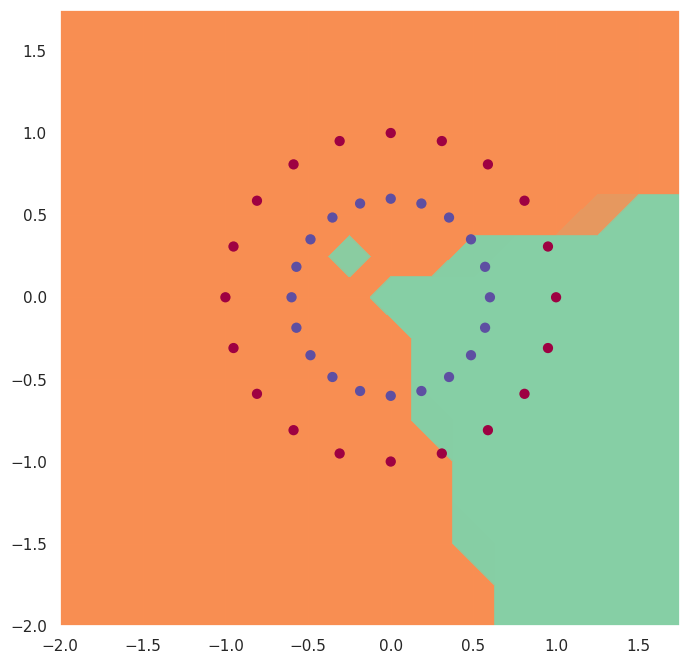

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

artists = []
for i,model in enumerate(models):
  print(f"Animating model {i}")
  h = 0.25
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  Z = Zvals(model)
  cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  scat = ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  artists.append(cs.collections + [scat])

#plt.show()

In [ ]:
import matplotlib.animation as animation
ani = animation.ArtistAnimation(fig, artists, interval=1000, blit=True,
                                repeat_delay=2000)

In [ ]:
HTML(ani.to_jshtml())